## <center> <u> GRU Trial: Adri Extra Work

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from dotenv import load_dotenv

load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [4]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

In [15]:
query="""
    select TO_TIMESTAMP(year || '-' || month || '-' || day || ' ' || hour || ':' || min, 'YYYY-MM-DD HH24:MI') AT TIME ZONE 'UTC' as ts,
    gridimport_wh - gridexport_wh as net_load  
    from agg.t_msb1m  
    where site = 23
"""

In [16]:
df = pd.read_sql_query(query, conn)

/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_4381/1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [17]:
df

,ts,net_load
0,2019-03-01 00:00:00,636.10
1,2019-03-01 00:15:00,350.44
2,2019-03-01 00:30:00,274.34
3,2019-03-01 00:45:00,115.93
4,2019-03-01 01:00:00,99.29
...,...,...
38034,2020-03-31 22:45:00,100.04
38035,2020-03-31 23:00:00,126.49
38036,2020-03-31 23:15:00,128.78
38037,2020-03-31 23:30:00,128.25


In [18]:
# Convert 'ts' to datetime and set as index
df['ts'] = pd.to_datetime(df['ts'])
df.set_index('ts', inplace=True)

df

,net_load
ts,
2019-03-01 00:00:00,636.10
2019-03-01 00:15:00,350.44
2019-03-01 00:30:00,274.34
2019-03-01 00:45:00,115.93
2019-03-01 01:00:00,99.29
...,...
2020-03-31 22:45:00,100.04
2020-03-31 23:00:00,126.49
2020-03-31 23:15:00,128.78


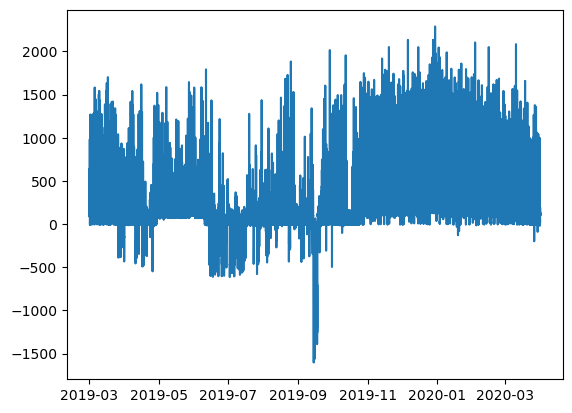

In [19]:
plt.plot(df.index, df.net_load)
plt.show()

### Normalise Net Load - Following Elian's Approach

In [21]:
df['net_load_norm'] = df['net_load'] / max(abs(df['net_load']))
df

,net_load,net_load_norm
ts,,
2019-03-01 00:00:00,636.10,0.277976
2019-03-01 00:15:00,350.44,0.153142
2019-03-01 00:30:00,274.34,0.119887
2019-03-01 00:45:00,115.93,0.050661
2019-03-01 01:00:00,99.29,0.043390
...,...,...
2020-03-31 22:45:00,100.04,0.043717
2020-03-31 23:00:00,126.49,0.055276
2020-03-31 23:15:00,128.78,0.056277


In [62]:
##Time Series into matrix

def df_to_X_y_with_ts(df, window_size):
    df_as_np = df.to_numpy()
    X = np.lib.stride_tricks.sliding_window_view(df_as_np, window_shape=window_size)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = df_as_np[window_size:]
    
    ts = df.index[window_size:]   # For y, we start from window_size to the end
    
    return X, y, ts

# 4 * hours * days
window_size = 4*24*1  # 1 week window size for hourly data - changed 7 for 1

X, y, ts = df_to_X_y_with_ts(df['net_load_norm'], window_size)

print(f'Given the array X: \n {X[0].flatten()}\n')
print(f'Predict this y value: \n {y[0]}\n')
print(f'First timestamp: {ts[0]}')


Given the array X: 
 [ 2.77975642e-01  1.53142248e-01  1.19886555e-01  5.06613994e-02
  4.33897209e-02  4.04312315e-02  3.78616720e-02  1.64198346e-01
  1.44441580e-01  8.38340624e-02  1.23906954e-01  5.84662177e-02
  9.13810508e-02  4.80962099e-02  1.24649854e-01  8.88202313e-02
  4.63482103e-02  9.33650304e-02  1.24807174e-01  7.78340537e-02
  4.15805413e-02  4.74057500e-02  4.66497402e-02  7.34946446e-02
  4.28705650e-01  4.17981672e-01  2.60561195e-01  2.31260351e-01
  2.07378306e-01  1.80966032e-01  2.60342695e-01  1.99892498e-01
  3.50849746e-01  4.29160130e-01  3.47462997e-01  2.26462092e-01
  2.38789860e-01  1.15953556e-01  5.81078778e-02  9.44968602e-02
 -2.63947945e-03  1.31100060e-04 -1.11871985e-03 -1.67370974e-03
 -2.35979933e-03 -8.91479813e-04  1.31536964e-03 -1.49890969e-03
 -2.04952957e-03 -1.50764960e-03 -2.25491953e-03 -2.70939943e-03
  1.50284282e-02  1.72177964e-03  3.53969899e-04  1.77421963e-03
  2.16751954e-03  5.89949832e-04  1.79169897e-04  3.94173917e-03
 -7.

## Splitting Data into Train, Test, Validation

In [63]:
def split_time_series(X, y, train_size, test_size, val_size, interval, ts):

    train_end = train_size * interval
    test_end = train_end + test_size * interval

    X_train, y_train, ts_train = X[:train_end], y[:train_end], ts[:train_end]
    X_test, y_test, ts_test = X[train_end:test_end], y[train_end:test_end], ts[train_end:test_end]
    X_val, y_val, ts_val = X[test_end:test_end+val_size*interval], y[test_end:test_end+val_size*interval], ts[test_end:test_end+val_size*interval]

    return X_train, y_train, ts_train,  X_test, y_test, ts_test, X_val, y_val, ts_val

interval = 96  # no. of 15-min increments in 1 day

# Use the function to split your dataset
X_train, y_train, ts_train, X_test, y_test, ts_test, X_val, y_val, ts_val = split_time_series(
    X, y,
    train_size=40*7,  # 40 weeks
    test_size=1,     # 1 day
    val_size=1,      # 1 day
    interval=interval,
    ts = ts
)

X_train.shape, y_train.shape, ts_train.shape, X_test.shape, y_test.shape, ts_test.shape, X_val.shape, y_val.shape, ts_val.shape

((26880, 96, 1),
 (26880,),
 (26880,),
 (96, 96, 1),
 (96,),
 (96,),
 (96, 96, 1),
 (96,),
 (96,))

## GRU Architecture and Modelling (Using MAE)

In [80]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import InputLayer, GRU, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError
from keras.metrics import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error

In [64]:
gru_model = keras.Sequential()
gru_model.add(InputLayer((window_size, 1)))
gru_model.add(GRU(64))
gru_model.add(layers.BatchNormalization())
gru_model.add(layers.Dense(1))
print(gru_model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 64)                12864     
                                                                 
 batch_normalization_5 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13,185
Trainable params: 13,057
Non-trainable params: 128
_________________________________________________________________
None


2024-03-25 18:19:11.481240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-25 18:19:11.481656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-25 18:19:11.482177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [65]:
checkpoint = ModelCheckpoint('gru_adri.keras', save_best_only=True)
gru_model.compile(loss='mae', optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

In [66]:
gru_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[checkpoint])

Epoch 1/10


2024-03-25 18:19:22.476345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-25 18:19:22.476903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-25 18:19:22.477610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

840/840 [==============================] - 11s 12ms/step - loss: 0.0414 - mean_absolute_error: 0.0414 - val_loss: 0.1180 - val_mean_absolute_error: 0.1180
Epoch 2/10
  1/840 [..............................] - ETA: 10s - loss: 0.0374 - mean_absolute_error: 0.0374

2024-03-25 18:19:33.369880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-25 18:19:33.370401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-25 18:19:33.370963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

840/840 [==============================] - 11s 13ms/step - loss: 0.0380 - mean_absolute_error: 0.0380 - val_loss: 0.0716 - val_mean_absolute_error: 0.0716
Epoch 3/10
840/840 [==============================] - 10s 12ms/step - loss: 0.0379 - mean_absolute_error: 0.0379 - val_loss: 0.0918 - val_mean_absolute_error: 0.0918
Epoch 4/10
840/840 [==============================] - 11s 13ms/step - loss: 0.0374 - mean_absolute_error: 0.0374 - val_loss: 0.0710 - val_mean_absolute_error: 0.0710
Epoch 5/10
840/840 [==============================] - 11s 13ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - val_loss: 0.0856 - val_mean_absolute_error: 0.0856
Epoch 6/10
840/840 [==============================] - 11s 13ms/step - loss: 0.0373 - mean_absolute_error: 0.0373 - val_loss: 0.0713 - val_mean_absolute_error: 0.0713
Epoch 7/10
840/840 [==============================] - 11s 13ms/step - loss: 0.0370 - mean_absolute_error: 0.0370 - val_loss: 0.0716 - val_mean_absolute_error: 0.0716
Epoch 8/10
840/

In [67]:
train_predictions = gru_model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

 14/840 [..............................] - ETA: 3s  

2024-03-25 18:21:12.408272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-25 18:21:12.409799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-25 18:21:12.410670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

840/840 [==============================] - 4s 4ms/step


,Train Predictions,Actuals
0,0.039850,0.183335
1,0.128561,0.138380
2,0.107817,0.232842
3,0.166485,0.132433
4,0.108580,0.098959
...,...,...
26875,0.226766,0.222936
26876,0.159845,0.138931
26877,0.104865,0.147680
26878,0.117665,0.302046


In [68]:
len(train_predictions)

26880

In [57]:
len(y_train)

26880

Training MAE: 0.03212820685692733


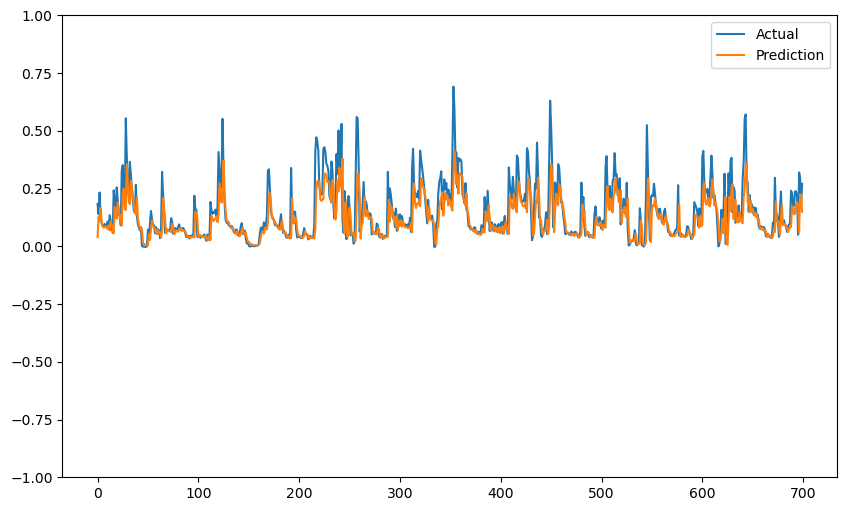

In [72]:
plt.figure(figsize=(10,6))
plt.plot(train_results['Actuals'][0:700], label='Actual')
plt.plot(train_results['Train Predictions'][0:700], label='Prediction')
plt.ylim((-1,1))
plt.legend()
print(f"Training MAE: {mean_absolute_error(y_train, train_predictions)}")

#### Validation Results

In [74]:
val_predictions = gru_model.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

3/3 [==============================] - 0s 5ms/step


,Val Predictions,Actuals
0,0.138417,0.120254
1,0.110924,0.152312
2,0.131658,0.124204
3,0.113382,0.133206
4,0.116583,0.221909
...,...,...
91,0.118846,0.199233
92,0.154419,0.092858
93,0.083874,0.216564
94,0.160469,0.132599


Validation MAE: 0.07136164021291508


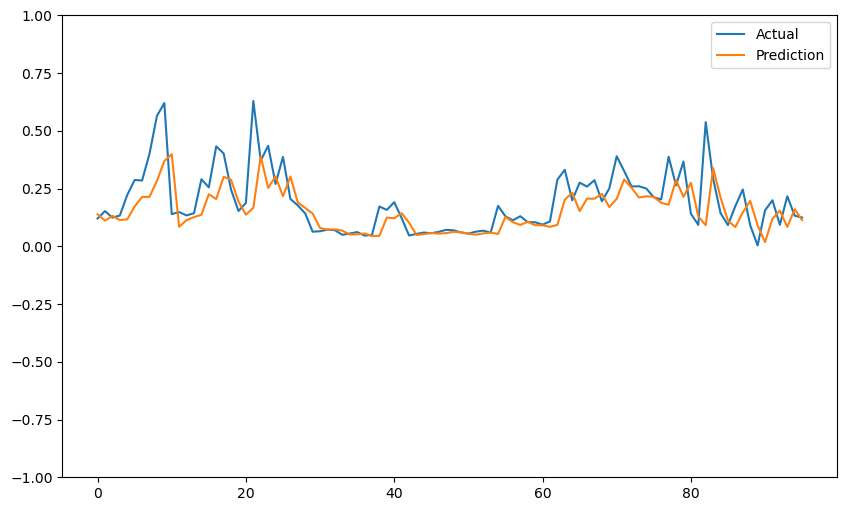

In [76]:
plt.figure(figsize=(10,6))
plt.plot(val_results['Actuals'], label='Actual')
plt.plot(val_results['Val Predictions'], label='Prediction')
plt.ylim((-1,1))
plt.legend()

print(f"Validation MAE: {mean_absolute_error(y_val, val_predictions)}")

#### Test Results

In [78]:
test_predictions = gru_model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

3/3 [==============================] - 0s 6ms/step


,Test Predictions,Actuals
0,0.196047,0.241202
1,0.190258,0.256545
2,0.204176,0.190396
3,0.164374,0.217643
4,0.182395,0.243186
...,...,...
91,0.264726,0.226379
92,0.183359,0.200325
93,0.164807,0.125375
94,0.117120,0.255741


Training MAE: 0.047635659095688544


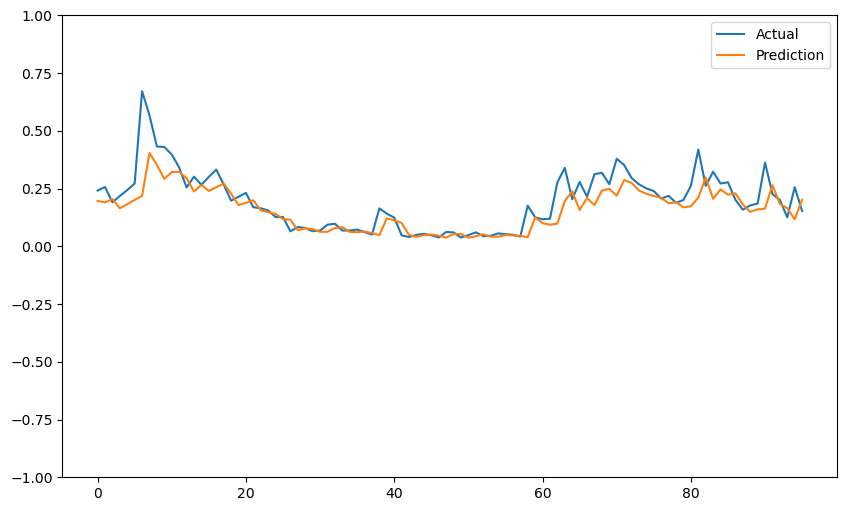

In [79]:
plt.figure(figsize=(10,6))
plt.plot(test_results['Actuals'], label='Actual')
plt.plot(test_results['Test Predictions'], label='Prediction')
plt.ylim([-1,1])
plt.legend()

print(f"Training MAE: {mean_absolute_error(y_test, test_predictions)}")

## GRU Architecture and Modelling (Using MSE)

In [81]:
gru_model2 = keras.Sequential()
gru_model2.add(InputLayer((window_size, 1)))
gru_model2.add(GRU(64))
gru_model2.add(layers.BatchNormalization())
gru_model2.add(layers.Dense(1))
print(gru_model2.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 64)                12864     
                                                                 
 batch_normalization_6 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13,185
Trainable params: 13,057
Non-trainable params: 128
_________________________________________________________________
None


2024-03-25 18:27:36.995638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-25 18:27:36.996121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-25 18:27:36.997049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [82]:
checkpoint2 = ModelCheckpoint('gru_adri2.keras', save_best_only=True)
gru_model2.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=[MeanSquaredError()])

In [83]:
gru_model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[checkpoint2])

Epoch 1/10


2024-03-25 18:28:48.228758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-25 18:28:48.230208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-25 18:28:48.231053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

840/840 [==============================] - 11s 13ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0221 - val_mean_squared_error: 0.0221
Epoch 2/10
  1/840 [..............................] - ETA: 11s - loss: 0.0076 - mean_squared_error: 0.0076

2024-03-25 18:28:59.495435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-25 18:28:59.496617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-25 18:28:59.497271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

840/840 [==============================] - 11s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 3/10
840/840 [==============================] - 11s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 4/10
840/840 [==============================] - 10s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 5/10
840/840 [==============================] - 11s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 6/10
840/840 [==============================] - 11s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 7/10
840/840 [==============================] - 11s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 8/10
840/840 [=======

In [84]:
train_predictions2 = gru_model2.predict(X_train).flatten()
train_results2 = pd.DataFrame(data={'Train Predictions':train_predictions2, 'Actuals':y_train})
train_results2

 13/840 [..............................] - ETA: 3s  

2024-03-25 18:30:38.781167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-25 18:30:38.781937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-25 18:30:38.782540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

840/840 [==============================] - 4s 4ms/step


,Train Predictions,Actuals
0,0.006870,0.183335
1,0.112754,0.138380
2,0.093271,0.232842
3,0.162718,0.132433
4,0.097687,0.098959
...,...,...
26875,0.242705,0.222936
26876,0.170861,0.138931
26877,0.098655,0.147680
26878,0.105350,0.302046


Training MAE: 0.05240199460547465


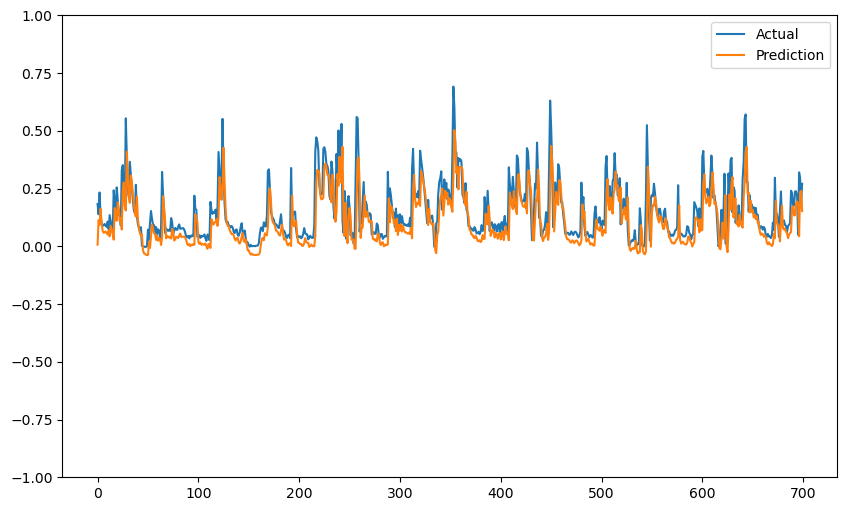

In [85]:
plt.figure(figsize=(10,6))
plt.plot(train_results2['Actuals'][0:700], label='Actual')
plt.plot(train_results2['Train Predictions'][0:700], label='Prediction')
plt.ylim((-1,1))
plt.legend()
print(f"Training MSE: {mean_absolute_error(y_train, train_predictions2)}")

#### Validation Results

In [86]:
val_predictions2 = gru_model2.predict(X_val).flatten()
val_results2 = pd.DataFrame(data={'Val Predictions':val_predictions2, 'Actuals':y_val})
val_results2

3/3 [==============================] - 0s 7ms/step


,Val Predictions,Actuals
0,0.134329,0.120254
1,0.098137,0.152312
2,0.119131,0.124204
3,0.098746,0.133206
4,0.101396,0.221909
...,...,...
91,0.100682,0.199233
92,0.148421,0.092858
93,0.068574,0.216564
94,0.154147,0.132599


Validation MAE: 0.08102325320889643


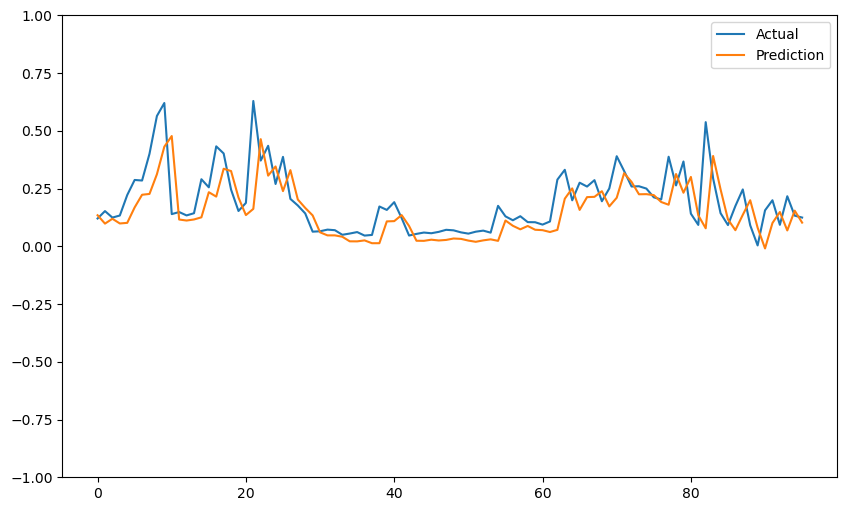

In [87]:
plt.figure(figsize=(10,6))
plt.plot(val_results2['Actuals'], label='Actual')
plt.plot(val_results2['Val Predictions'], label='Prediction')
plt.ylim((-1,1))
plt.legend()

print(f"Validation MAE: {mean_absolute_error(y_val, val_predictions2)}")